In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymc3 import  *
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, summary, traceplot, forestplot
from pymc3.glm import GLM
from sklearn.preprocessing import StandardScaler 

from src import load_clean_data as load
%matplotlib inline

In [723]:
df = load.load_all_data(2015)
df.head()

/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (13,14,19,20,193,194,265,266) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,...,perc_male,perc_white,perc_black,perc_hisp,perc_20_44,ADULTMEN,MSM12MTH,MSM5YEAR,%msm12month,%msm5yr
0,1001,Autauga County,AL,2015,0.0,5.0,10.9,225.5,1.0,0.0,...,48.6,79.2,19.1,2.5,32.4,19410,333,514,1.715611,2.648120
1,1003,Baldwin County,AL,2015,0.0,15.0,8.7,163.9,4.0,0.0,...,48.8,88.2,10.0,4.5,29.4,69724,925,1429,1.326659,2.049509
2,1005,Barbour County,AL,2015,0.0,0.0,0.0,436.0,1.0,0.0,...,53.7,48.7,47.3,4.7,33.6,11567,82,127,0.708913,1.097951
3,1007,Bibb County,AL,2015,0.0,0.0,0.0,191.9,0.0,0.0,...,53.9,77.9,22.0,2.0,33.7,9508,119,184,1.251578,1.935212
4,1009,Blount County,AL,2015,0.0,5.0,10.4,95.4,1.0,0.0,...,49.6,96.8,2.1,8.5,30.2,21368,601,928,2.812617,4.342943


In [724]:
df.shape

(3140, 44)

In [575]:
df_no_zero_outlier = df[((df.HIVincidence > 0) & (df.HIVincidence < 130))].copy()
#df_no_zero_outlier['log_household_income'] = np.log10(df_no_zero_outlier.household_income)
df_no_zero_outlier.head()

,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,...,perc_male,perc_white,perc_black,perc_hisp,perc_20_44,ADULTMEN,MSM12MTH,MSM5YEAR,%msm12month,%msm5yr
0,1001,Autauga County,AL,2015,0.0,5.0,10.9,225.5,1.0,0.0,...,48.6,79.2,19.1,2.5,32.4,19410,333,514,1.715611,2.648120
1,1003,Baldwin County,AL,2015,0.0,15.0,8.7,163.9,4.0,0.0,...,48.8,88.2,10.0,4.5,29.4,69724,925,1429,1.326659,2.049509
4,1009,Blount County,AL,2015,0.0,5.0,10.4,95.4,1.0,0.0,...,49.6,96.8,2.1,8.5,30.2,21368,601,928,2.812617,4.342943
5,1011,Bullock County,AL,2015,0.0,8.0,90.7,691.4,0.0,0.0,...,54.2,27.1,72.0,4.0,35.2,4597,73,113,1.587992,2.458125
7,1015,Calhoun County,AL,2015,0.0,10.0,10.3,211.2,5.0,0.0,...,48.2,76.9,21.6,3.4,32.4,43018,692,1070,1.608629,2.487331


In [721]:
df_no_zero_outlier.shape

(746, 44)

In [138]:
def score_model(data, model_list, features, target_col):
    # define and scale the feature matrix
    X = data[features].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # define the target vector
    y = df_no_zero_outlier.HIVincidence.values
    
    # iterate the list of models to populate the score vector
    score = [features]
    for model in model_list:
        model.fit(X, y)
        score.append(round(model.criterion_.min(), 2))
    
    return score


def model_selection(data, features_list, target_col):
    # Instanciate the models for bic and aic scoring
    model_bic = LassoLarsIC(criterion='bic')
    model_aic = LassoLarsIC(criterion='aic')
    model_lst = [model_bic, model_aic]
    
    # iterate the features list to populate the scores list
    score_lst = []
    for features in features_list:
        score = score_model(data, model_lst, features, target_col)
        score_lst.append(score)
        
    # turn scores list into a pandas df
    score_df = pd.DataFrame(score_lst, columns=['Features', "BIC", 'AIC'])
    score_df['Features'] = score_df['Features'].apply(lambda x: ' + '.join(x))
    score_df['num_features'] = [len(x) for x in score_df.Features]
    
    return score_df
       

In [719]:
features_list = [['HIVprevalence'], ['perc_black'], ['HIVprevalence', 'perc_black'], ['HIVprevalence', 'perc_white'], 
                  ['HIVprevalence', 'perc_black', 'perc_white'],
                  ['HIVprevalence', 'perc_black', 'pctunins'], 
                  ['HIVprevalence', 'perc_black', 'pctunins', 'poverty_rate'],
                  ['HIVprevalence', 'perc_black', 'pctunins', 'poverty_rate', 'pctunmetneed'],
                  ['HIVprevalence', 'perc_black', 'pctunins', 'pctunmetneed'], 
                  ['HIVprevalence', 'perc_black', 'pctunins', 'drugdep'], 
                  ['HIVprevalence', 'perc_black', 'pctunins', 'nonmedpain'], 
                  ['HIVprevalence','perc_black','pctunins','poverty_rate','drugdep','nonmedpain'],
                  ['HIVprevalence', 'perc_black', 'pctunins', 'log_household_income'],
                  ['HIVprevalence', 'perc_black', 'pctunins', 'log_household_income', '%msm12month'],
                  ['HIVprevalence', 'perc_black', 'pctunins', 'log_household_income', '%msm5yr'], 
                  ['HIVprevalence', 'perc_black', 'pctunins', 'log_household_income', '%msm5yr', 'perc_20_44'], 
                  ['HIVprevalence', 'perc_black', 'pctunins', 'log_household_income', '%msm5yr', 'perc_20_44', 'Med_MH_fac'], 
                  ['HIVprevalence', 'perc_black', 'pctunins', 'log_household_income', '%msm5yr', 'perc_20_44', 'Med_MH_fac', 'Med_SMAT_fac'], 
                  ['HIVprevalence', 'perc_black', 'pctunins', 'log_household_income', '%msm5yr', 'perc_20_44', 'Med_MH_fac', 'Med_SMAT_fac', 'mme_percap'], 
                  ['HIVprevalence', 'perc_black', 'pctunins', 'log_household_income', '%msm5yr', 'perc_20_44', 'Med_MH_fac', 'Med_SMAT_fac', 'mme_percap', 'partD30dayrxrate'], 
                  ['HIVprevalence', 'perc_black', 'pctunins', 'log_household_income', '%msm5yr', 'perc_20_44', 'Med_MH_fac', 'Med_SMAT_fac', 'mme_percap', 'partD30dayrxrate', 'bup_phys'], 
                  ['HIVprevalence', 'perc_black', 'pctunins', 'log_household_income', 'perc_20_44', 'mme_percap']]

df = model_selection(df_no_zero_outlier, features_list, target_col='HIVincidence')

df

,Features,BIC,AIC,num_features
0,HIVprevalence,378.82,374.20,13
1,perc_black,405.05,400.43,10
2,HIVprevalence + perc_black,299.28,290.05,26
3,HIVprevalence + perc_white,327.24,318.01,26
4,HIVprevalence + perc_black + perc_white,305.77,291.92,39
5,HIVprevalence + perc_black + pctunins,273.82,259.97,37
6,HIVprevalence + perc_black + pctunins + poverty_rate,273.85,260.01,52
7,HIVprevalence + perc_black + pctunins + poverty_rate + pctunmetneed,274.53,260.69,67
8,HIVprevalence + perc_black + pctunins + pctunmetneed,274.53,260.69,52
9,HIVprevalence + perc_black + pctunins + drugdep,275.06,260.88,47


In [720]:
# find the features resulting in the lowest BIC score
lowest = df[df.BIC == df.BIC.min()]
lowest

,Features,BIC,AIC,num_features
12,HIVprevalence + perc_black + pctunins + log_household_income,269.71,251.25,60


In [333]:

X = df_no_zero_outlier[['HIVprevalence']].values


y = df_no_zero_outlier.HIVincidence.values # target value

data = dict(x=X, y=y)

with Model() as model:
    GLM.from_formula('y ~ 1 + x', data)
    trace = sample(1000, n_init=50000, tune=1000, njobs=4) # draw 3000 posterior samples using NUTS sampling

100%|██████████| 2000/2000 [00:10<00:00, 188.59it/s]


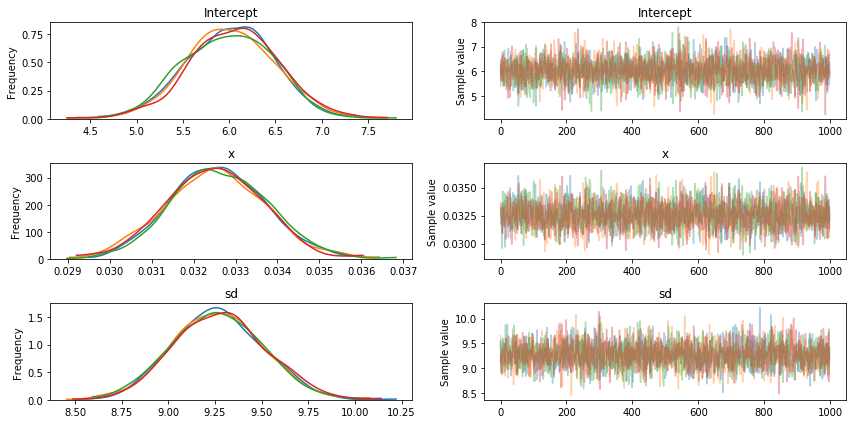

In [334]:
from pymc3 import traceplot  
traceplot(trace)
plt.tight_layout();

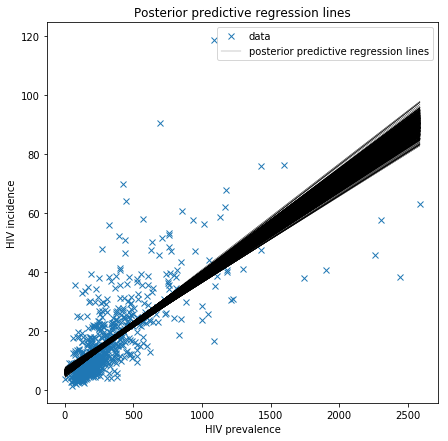

In [335]:
plt.figure(figsize=(7, 7))
plt.plot(X, y, 'x', label='data')
plot_posterior_predictive_glm(trace, eval=X, samples=1000, label='posterior predictive regression lines')
plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('HIV prevalence')
plt.ylabel('HIV incidence');

In [354]:
X = df_no_zero_outlier[['HIVprevalence', 
                             'perc_black', 
                             'pctunins', 
                             'log_household_income']].values


scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df_no_zero_outlier.HIVincidence.values # target value

data = dict(x1=X[:,0], x2=X[:,1], x3=X[:,2], x4=X[:,3], y=y)

with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    GLM.from_formula('y ~ 1 + x1 + x2 + x3 +x4', data)
    trace = sample(1000, n_init=50000, tune=1000, njobs=4) # draw 3000 posterior samples using NUTS sampling

100%|██████████| 2000/2000 [00:12<00:00, 156.33it/s]


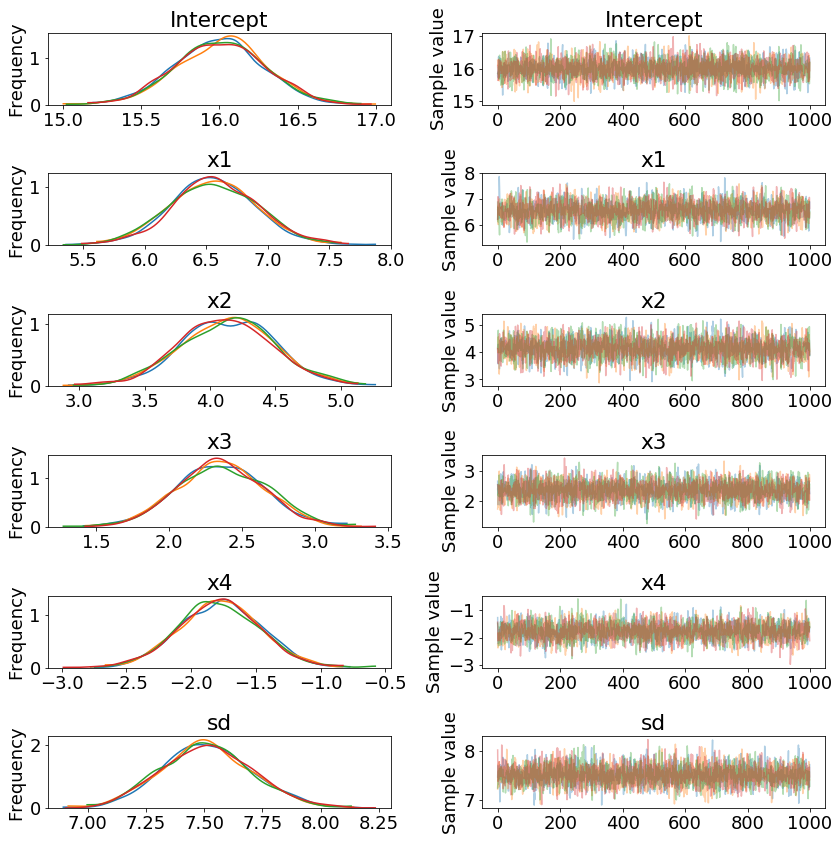

In [679]:
 traceplot(trace)
plt.tight_layout()
plt.savefig('images/pooledmodel_traceplot.png', bbox_inches='tight');

In [356]:
intercept, b1, b2, b3, b4 = trace['Intercept'].mean(), trace['x1'].mean(), trace['x2'].mean(), trace['x3'].mean(), trace['x4'].mean()
intercept, b1, b2, b3, b4

(16.003856496141015,
 6.5601173146039535,
 4.1289598562615115,
 2.356315085080865,
 -1.778792311374954)

In [570]:
pooled_pred = trace['Intercept'].mean(axis=0) + trace['x1'].mean(axis=0) * X[:,0] + trace['x2'].mean(axis=0) * X[:,1] + trace['x3'].mean(axis=0) * X[:,2] + trace['x4'].mean(axis=0) * X[:,3]
pooled_resid = pooled_pred - HIV_incidence
pooled_sum_resid_square = np.power(pooled_resid, 2).sum()
pooled_rmse = np.sqrt(pooled_sum_resid_square/len(df_no_zero_outlier.HIVincidence.values))
print('Pooled Model RMSE is {}'.format(pooled_rmse))

Pooled Model RMSE is 7.47541660884293


In [281]:

X = df_no_zero_outlier[['HIVprevalence']].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df_no_zero_outlier.HIVincidence.values # target value

with Model() as pooled_model:

    intercept = Normal('intercept', 0, sd=1e5)
    slope = Normal('slope', 0, sd=1e5)
    
    sigma = HalfCauchy('sigma', 5)

    theta = intercept + slope*X

    y = Normal('y', theta, sd=sigma, observed=y)


In [282]:
with pooled_model:
    pooled_trace = sample(1000, n_init=50000, tune=1000)

100%|██████████| 2000/2000 [06:31<00:00,  5.10it/s]/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.892086859125, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



In [254]:
b0, b1 = pooled_trace['intercept'].mean(axis=0), pooled_trace['slope'].mean(axis=0)
b0, b1

(15.999594613621939, 0.00041276790385570597)

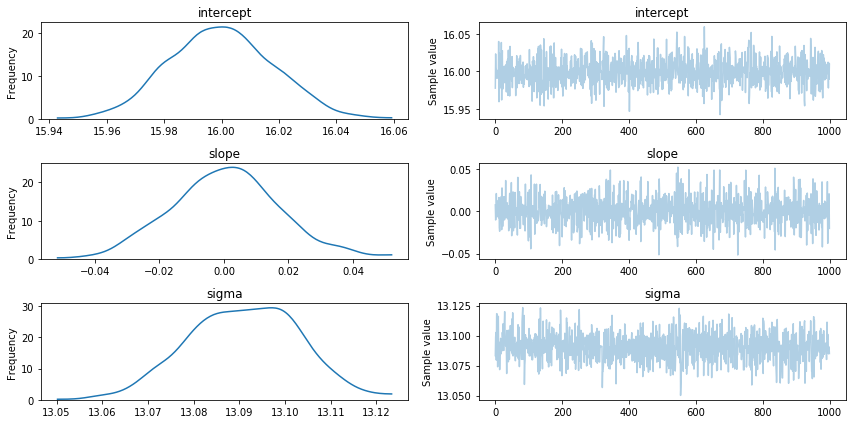

In [255]:

traceplot(pooled_trace);

In [150]:
 
summary(pooled_trace) 


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.999            0.523            0.023            [4.867, 6.913]
  0.559            0.022            0.001            [0.523, 0.607]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  4.952          5.652          6.009          6.357          7.029
  0.515          0.543          0.559          0.575          0.602


sigma:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  9.596            0.255            0.009            [9.089, 10.072]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  9.105          9.419          9.589  

Text(0,0.5,'HIV incidence')

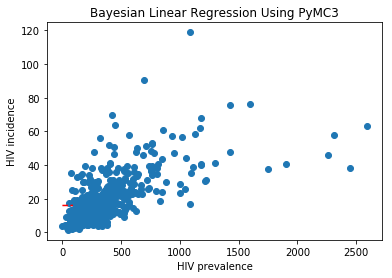

In [280]:
plt.scatter(df_no_zero_outlier[['HIVprevalence']].values, df_no_zero_outlier.HIVincidence.values)
xvals = np.linspace(0, 90)
plt.plot(xvals, b1*xvals+b0, 'r--');
plt.title('Bayesian Linear Regression Using PyMC3')
plt.xlabel('HIV prevalence')
plt.ylabel('HIV incidence')

In [155]:
HIV_incidence_pred = b0 + b1*perc_black
resid = HIV_incidence_pred - HIV_incidence
sum_resid_square = np.power(resid, 2).sum()
rmse = np.sqrt(sum_resid_square/len(perc_black))
print('Model RMSE is {}'.format(rmse))

Model RMSE is 9.56715807400747


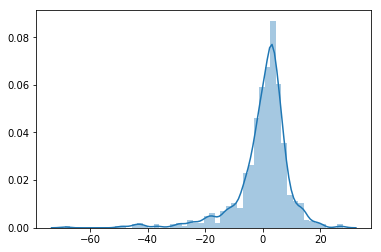

In [156]:
sns.distplot(resid);

In [160]:
X = df_no_zero_outlier[['HIVprevalence', 
                             'perc_black', 
                             'pctunins', 
                             'log_household_income']].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

HIV_incidence = df_no_zero_outlier.HIVincidence.values # target value

with Model() as pooled_model_X:

    beta = Normal('beta', 0, sd=1e5, shape=X.shape[1]+1)
    sigma = HalfCauchy('sigma', 5)
    
    #theta = beta[0] + X.dot(beta.T[1:])
    theta = beta[0] + beta[1] * X[:,0] + beta[2] * X[:,1] + beta[3] * X[:,2] + beta[4] * X[:,3]
    y = Normal('y', theta, sd=sigma, observed=HIV_incidence)


In [161]:
with pooled_model_X:
    pooled_X_trace = sample(1000, n_init=50000, tune=1000)

100%|██████████| 2000/2000 [00:05<00:00, 390.44it/s]


In [162]:
b0, b1, b2, b3, b4 = pooled_X_trace['beta'].mean(axis=0)
b0, b1, b2, b3, b4

(15.986696794447353,
 6.5363824656596181,
 4.1560885216874999,
 2.366121198467527,
 -1.7557289414066122)

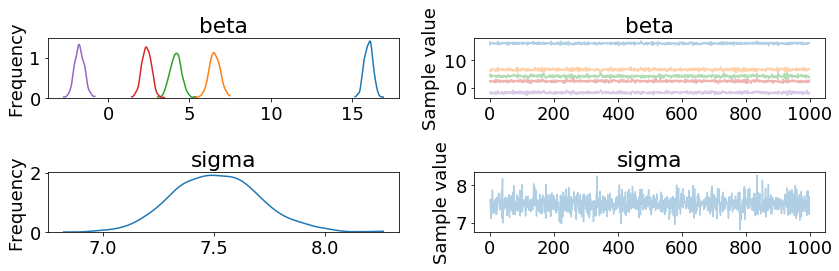

In [681]:
traceplot(pooled_X_trace)
plt.tight_layout()
plt.savefig('images/pooledmodel_traceplot2.png', bbox_inches='tight');

In [482]:
beta_arr = pooled_X_trace['beta'].mean(axis=0)
HIV_incidence_pred = beta_arr[0] + X.dot(beta_arr.T[1:])
pooled_resid = HIV_incidence_pred - HIV_incidence
pooled_sum_resid_square = np.power(pooled_resid, 2).sum()
pooled_rmse = np.sqrt(pooled_sum_resid_square/len(df_no_zero_outlier.HIVincidence.values))
print('Pooled Model RMSE is {}'.format(pooled_rmse))

Pooled Model RMSE is 7.475432751585583


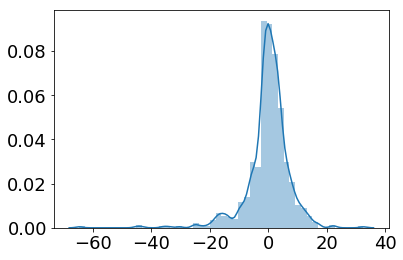

In [532]:
sns.distplot(pooled_resid);

In [168]:
betas_df = pd.DataFrame(beta_arr.T, index=['intercept',
                                           'HIVprevalence', 
                             'perc_black', 
                             'pctunins', 
                             'log_household_income'])
betas_df

,0
intercept,15.986697
HIVprevalence,6.536382
perc_black,4.156089
pctunins,2.366121
log_household_income,-1.755729


In [169]:
 summary(pooled_X_trace) 


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  15.987           0.268            0.008            [15.490, 16.495]
  6.536            0.343            0.012            [5.906, 7.270]
  4.156            0.348            0.013            [3.468, 4.794]
  2.366            0.298            0.010            [1.722, 2.880]
  -1.756           0.301            0.010            [-2.341, -1.144]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  15.490         15.802         15.995         16.165         16.495
  5.844          6.311          6.528          6.772          7.223
  3.497          3.921          4.159          4.385          4.849
  1.756          2.162          2.362          2.572          2.948
  -2.321         -1.971         -1.763         -1.548         -1.121


sig

In [534]:
us_states = df_no_zero_outlier.STATEABBREVIATION.unique()
states = len(us_states)
state_lookup = dict(zip(us_states, range(len(us_states))))
state = df_no_zero_outlier['state_code'] = df_no_zero_outlier.STATEABBREVIATION.replace(state_lookup).values

In [546]:
X = df_no_zero_outlier[['HIVprevalence', 
                             'perc_black', 
                             'pctunins', 
                             'log_household_income']].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df_no_zero_outlier.HIVincidence.values # target value


with Model() as unpooled_model:

    intercept = Normal('intercept', 0, sd=1e5, shape=states)
    beta1 = Normal('beta1', 0, sd=1e5)
    beta2 = Normal('beta2', 0, sd=1e5)
    beta3 = Normal('beta3', 0, sd=1e5)
    beta4 = Normal('beta4', 0, sd=1e5)
    
    sigma = HalfCauchy('sigma', 5)

    theta = intercept[state] + beta1 * X[:,0] + beta2 * X[:,1] + beta3 * X[:,2] + beta4 * X[:,3]
    y = Normal('y', theta, sd=sigma, observed=y)

In [547]:
with unpooled_model:
    unpooled_trace = sample(1000, n_init=50000, tune=1000)

100%|██████████| 2000/2000 [00:07<00:00, 253.95it/s]


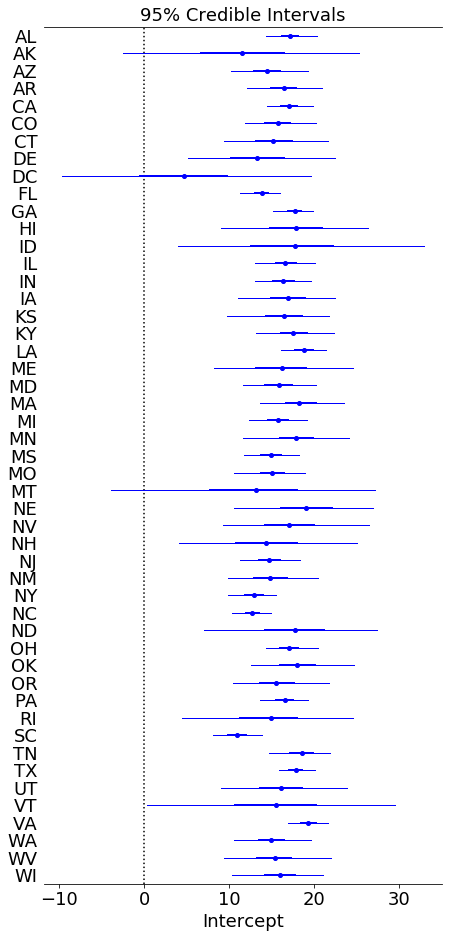

In [549]:
plt.figure(figsize=(6,14))
forestplot(unpooled_trace, varnames=['intercept'], ylabels=us_states, xtitle='Intercept');


In [548]:
X.shape

(746, 4)

In [550]:
summary(unpooled_trace) 


intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  17.165           1.475            0.040            [14.327, 20.291]
  11.552           7.387            0.250            [-2.468, 25.250]
  14.467           2.320            0.064            [10.206, 19.240]
  16.387           2.277            0.060            [12.127, 20.879]
  17.073           1.401            0.043            [14.480, 19.798]
  15.704           2.144            0.056            [11.872, 20.226]
  15.229           3.184            0.085            [9.435, 21.629]
  13.300           4.537            0.111            [5.175, 22.391]
  4.605            7.596            0.234            [-9.584, 19.643]
  13.825           1.223            0.033            [11.234, 15.992]
  17.691           1.196            0.034            [15.105, 19.837]
  17.868           4.377            0.113            [8.990, 26.299]
  17.59

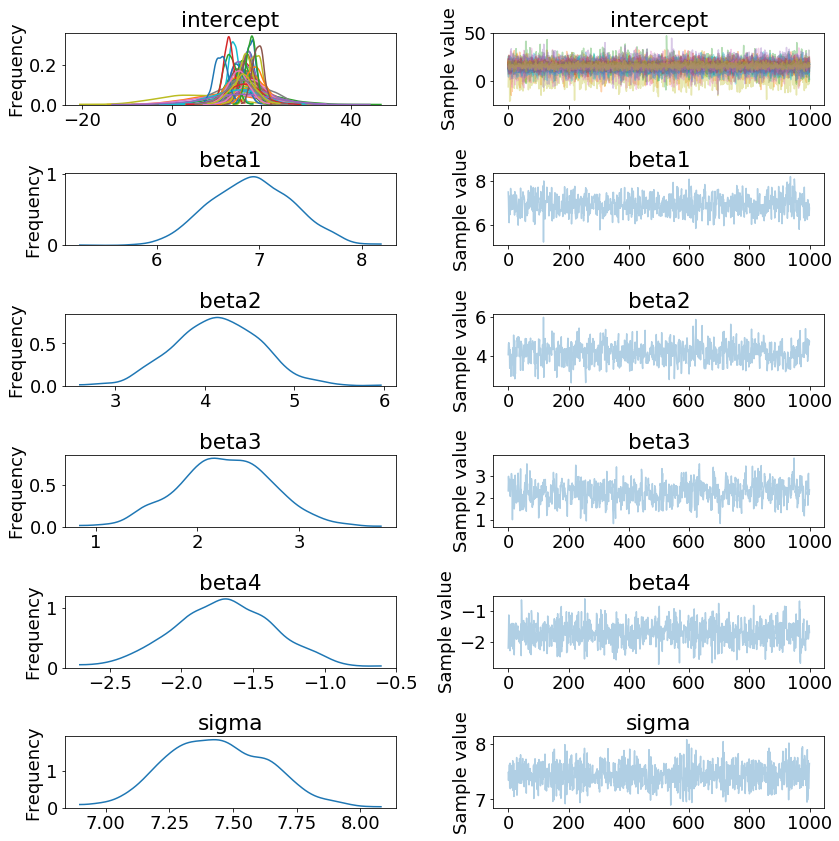

In [678]:
traceplot(unpooled_trace)
plt.tight_layout()
plt.savefig('images/unpooledmodel_traceplot.png', bbox_inches='tight');

In [567]:
y_pred_unpooled = unpooled_trace['intercept'].mean(axis=0)[state] + unpooled_trace['beta1'].mean(axis=0) * X[:,0] + unpooled_trace['beta2'].mean(axis=0) * X[:,1] + unpooled_trace['beta3'].mean(axis=0) * X[:,2] + unpooled_trace['beta4'].mean(axis=0) * X[:,3]
unpooled_resid = y_pred_unpooled - df_no_zero_outlier.HIVincidence.values
unpooled_sum_resid_square = np.power(unpooled_resid, 2).sum()
unpooled_rmse = np.sqrt(unpooled_sum_resid_square/len(df_no_zero_outlier.HIVincidence.values))
print('Unpooled Model RMSE is {}'.format(unpooled_rmse))

Unpooled Model RMSE is 7.152646102910631


In [397]:
import pymc3
#pooled_perc_black = pymc3.stats.waic(model=pooled_model_perc_black, trace=pooled_X_trace)

#pooled_model_perc_black

#print(round(pooled_perc_black[0], 2), round(pooled_perc_black[1], 2))


/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/pymc3/stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


5143.71 109.1
5295.42 117.58


/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/pymc3/stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


In [184]:
pooled_perc_black_loo = pymc3.stats.loo(model=pooled_model_perc_black, trace=pooled_X_trace)
pooled_loo = pymc3.stats.loo(model=pooled_model_X, trace=pooled_X_trace)
unpooled_loo = pymc3.stats.loo(model=unpooled_model, trace=unpooled_trace)

print(round(pooled_perc_black_loo[0], 2), round(pooled_perc_black[1], 2))
print(round(pooled_loo[0], 2), round(pooled[1], 2))
print(round(unpooled_loo[0], 2), round(unpooled[1], 2))

/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/pymc3/stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


nan 352001.94
5149.12 109.1
5173.84 104.37


In [221]:
multi_loo = pymc3.stats.loo(model=multi_model, trace=multi_trace)
print(round(multi_loo[0], 2), round(multi_loo[1], 2))

/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/pymc3/stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


5822.81 102.03


In [222]:
multi_trace['beta1'].shape

(1000, 49, 4)

In [227]:
multi_trace['beta1'][:, 10, :].mean(axis=0)

array([ 0.04418554,  2.25100186, -0.13868075, -1.08591921])

In [403]:

X = df_no_zero_outlier['HIVprevalence'].values

HIV_incidence = df_no_zero_outlier.HIVincidence.values # target value


with Model() as multi_model:
    #set intercept hyper priors
    mu_intercept = Normal('mu_intercep', mu=0., sd=1e5)
    sigma_intercept = HalfCauchy('sigma_intercep', 5)
    
    #set slope hyper priors
    mu_beta = Normal('mu_beta', mu=0., sd=1e5)
    sigma_beta = HalfCauchy('sigma_beta', 5)
    
    
    intercept = Normal('beta0', mu=mu_intercept, sd=sigma_intercept, shape=states)
    beta = Normal('beta1', mu=mu_beta, sd=sigma_beta, shape=states)
    
    sigma = HalfCauchy('sigma', 5)

    theta = intercept[state] + beta[state] * X
    y = Normal('y', theta, sd=sigma, observed=HIV_incidence)
    multi_trace = sample(1000, n_init=150000, tune=50000)

100%|██████████| 51000/51000 [04:28<00:00, 190.28it/s]/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.694759968235, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 16 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



In [372]:
with multi_model:
    multi_trace = sample(1000, n_init=150000, tune=50000)

100%|█████████▉| 50993/51000 [04:12<00:00, 201.66it/s]/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 51000/51000 [04:12<00:00, 201.65it/s]


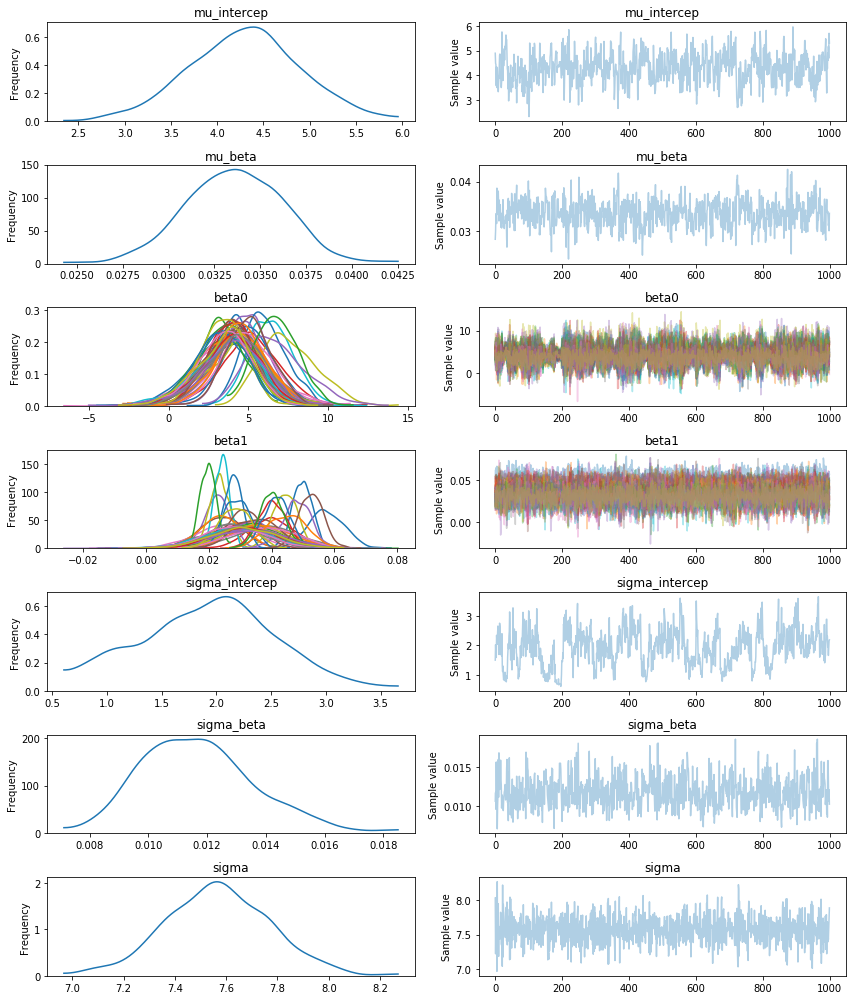

In [373]:
traceplot(multi_trace);

In [456]:
from pymc3 import HalfNormal, StudentT
from sklearn.preprocessing import StandardScaler

X = df_no_zero_outlier[['HIVprevalence', 
                             'perc_black', 
                             'pctunins', 
                             'log_household_income']].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

HIV_incidence = df_no_zero_outlier.HIVincidence.values # target value


# scaler = StandardScaler()
# X = scaler.fit_transform(X)

HIV_incidence = df_no_zero_outlier.HIVincidence.values # target value

with Model() as multi_model_4f:
    #set intercept hyper priors
    mu_intercept = Normal('mu_intercep', mu=0., sd=1e5)
    sigma_intercept = HalfCauchy('sigma_intercep', 5)
    
    #set beta1 hyper priors
    mu_beta1 = Normal('mu_beta1', mu=0., sd=1e5)
    sigma_beta1 = HalfCauchy('sigma_beta1', 5)
    
    #set beta2 hyper priors
    mu_beta2 = Normal('mu_beta2', mu=0., sd=1e5)
    sigma_beta2 = HalfCauchy('sigma_beta2', 5)
    
    #set beta3 hyper priors
    mu_beta3 = Normal('mu_beta3', mu=0., sd=1e5)
    sigma_beta3 = HalfCauchy('sigma_beta3', 5)
    
    #set beta4 hyper priors
    mu_beta4 = Normal('mu_beta4', mu=0., sd=1e5)
    sigma_beta4 = HalfCauchy('sigma_beta4', 5)
    
    intercept = Normal('intercept', mu=mu_intercept, sd=sigma_intercept, shape=states)
    beta1 = Normal('beta1', mu=mu_beta1, sd=sigma_beta1, shape=states)
    beta2 = Normal('beta2', mu=mu_beta2, sd=sigma_beta2, shape=states)
    beta3 = Normal('beta3', mu=mu_beta3, sd=sigma_beta3, shape=states)
    beta4 = Normal('beta4', mu=mu_beta3, sd=sigma_beta4, shape=states)
    
    sigma = HalfCauchy('sigma', 5)

    HIV_like = intercept[state] + beta1[state] * X[:,0] + beta2[state] * X[:,1] + beta3[state] * X[:,2] + beta4[state] * X[:,3]
    y = Normal('y', HIV_like, sd=sigma, observed=HIV_incidence)

In [391]:
with multi_model_4f:
    multi_trace_4f = sample(1000, n_init=150000, tune=50000)

100%|█████████▉| 50996/51000 [15:05<00:00, 56.32it/s]/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 7 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 51000/51000 [15:05<00:00, 56.32it/s]


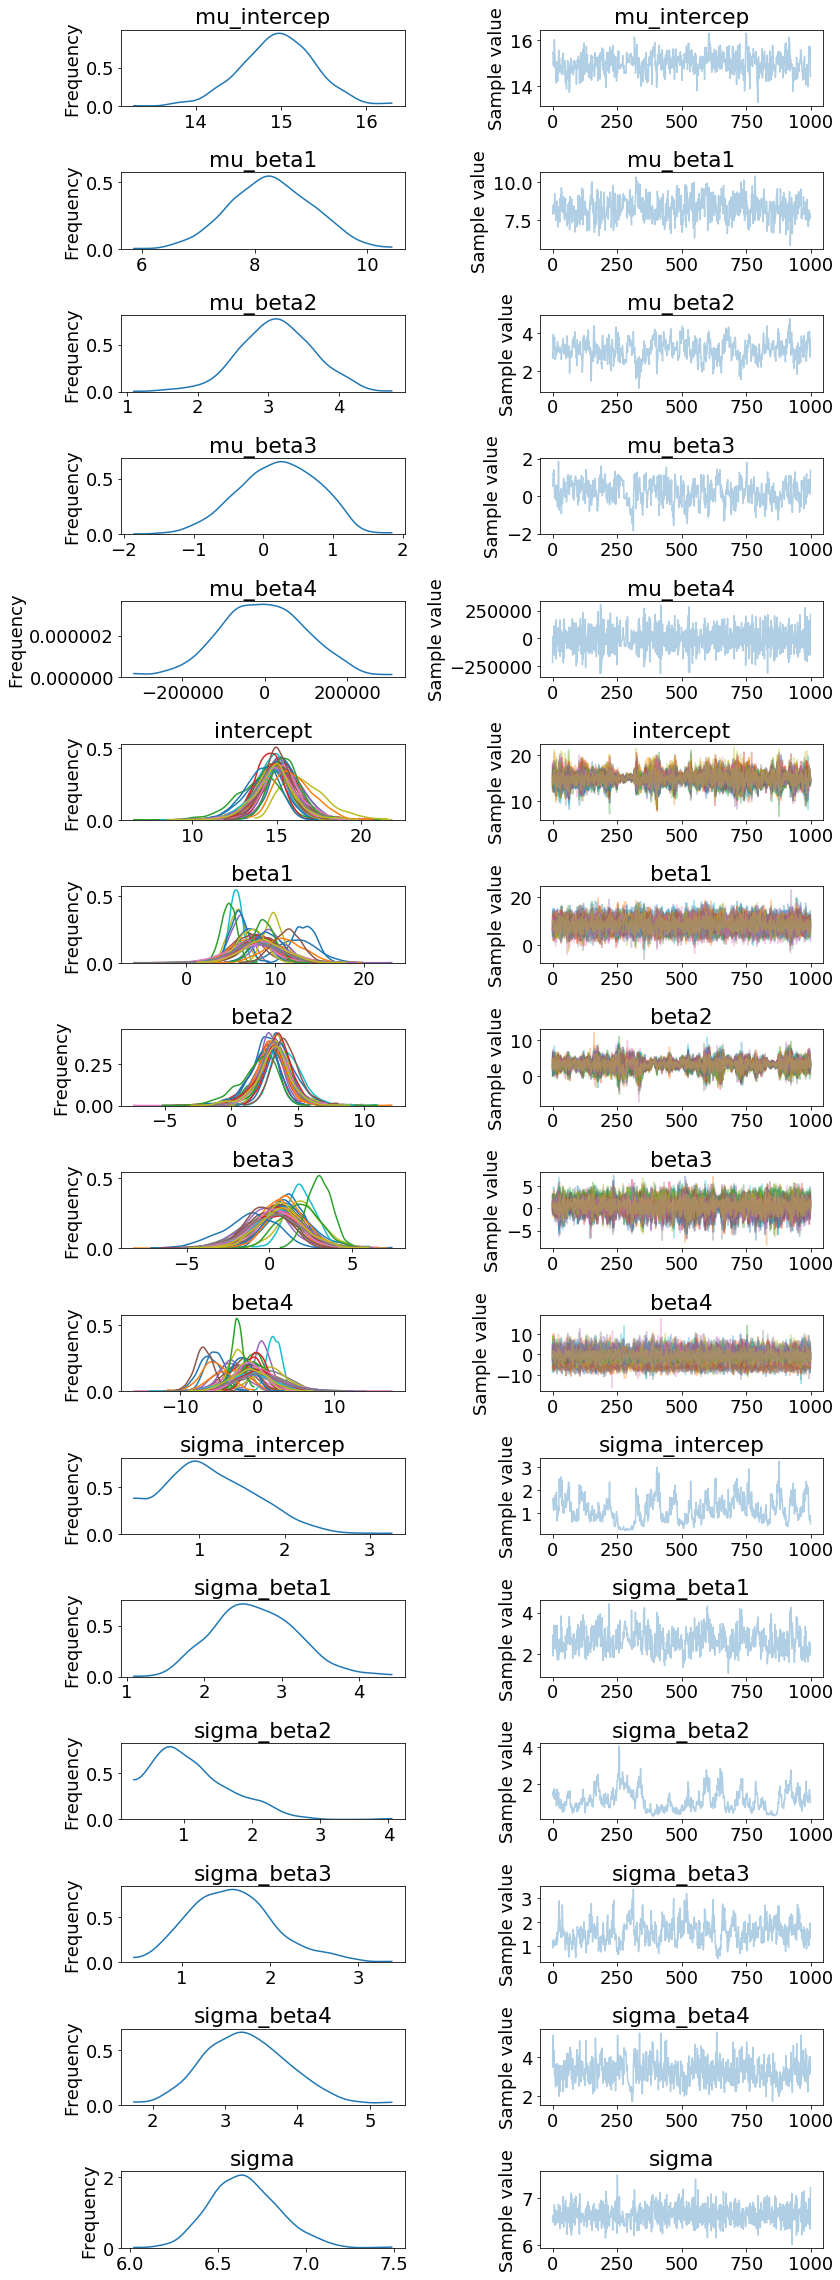

In [677]:
traceplot(multi_trace_4f)
plt.savefig('images/multimodel_traceplot.png', bbox_inches='tight');

In [399]:
pooled = pymc3.stats.waic(model=pooled_model_X, trace=pooled_X_trace)
unpooled = pymc3.stats.waic(model=unpooled_model, trace=unpooled_trace)
multi = pymc3.stats.waic(model=multi_model_4f, trace=multi_trace_4f)

print('WAIC for the pooled model is {} ({})'.format(round(pooled[0], 2), round(pooled[1], 2)))
print('WAIC for the unpooled model is {} ({})'.format(round(unpooled[0], 2), round(unpooled[1], 2)))
print('WAIC for the multilevel model is {} ({})'.format(round(multi[0], 2), round(multi[1], 2)))

/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/pymc3/stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC for the pooled model is 5143.71 (109.1)
WAIC for the unpooled model is 5295.42 (117.58)
WAIC for the multilevel model is 5066.49 (102.36)


In [402]:
pooled_loo = pymc3.stats.loo(model=pooled_model_X, trace=pooled_X_trace)
unpooled_loo = pymc3.stats.loo(model=unpooled_model, trace=unpooled_trace)
multi_loo = pymc3.stats.loo(model=multi_model_4f, trace=multi_trace_4f)
print('LOO for the pooled model is {} ({})'.format(round(pooled_loo[0], 2), round(pooled_loo[1], 2)))
print('LOO for the unpooled model is {} ({})'.format(round(unpooled_loo[0], 2), round(unpooled_loo[1], 2)))
print('LOO for the multilevel model is {} ({})'.format(round(multi_loo[0], 2), round(multi_loo[1], 2)))

/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/pymc3/stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO for the pooled model is 5149.12 (110.41)
LOO for the unpooled model is 5304.53 (119.12)
LOO for the multilevel model is 5092.1 (103.67)


In [717]:
pooled_pred = trace['Intercept'].mean(axis=0) + trace['x1'].mean(axis=0) * X[:,0] + trace['x2'].mean(axis=0) * X[:,1] + trace['x3'].mean(axis=0) * X[:,2] + trace['x4'].mean(axis=0) * X[:,3]
pooled_resid = pooled_pred - HIV_incidence
pooled_sum_resid_square = np.power(pooled_resid, 2).sum()
pooled_rmse = np.sqrt(pooled_sum_resid_square/len(df_no_zero_outlier.HIVincidence.values))
print('Pooled Model RMSE is {}'.format(round(pooled_rmse, 2)))

y_pred_unpooled = unpooled_trace['intercept'].mean(axis=0)[state] + unpooled_trace['beta1'].mean(axis=0) * X[:,0] + unpooled_trace['beta2'].mean(axis=0) * X[:,1] + unpooled_trace['beta3'].mean(axis=0) * X[:,2] + unpooled_trace['beta4'].mean(axis=0) * X[:,3]
unpooled_resid = y_pred_unpooled - df_no_zero_outlier.HIVincidence.values
unpooled_sum_resid_square = np.power(unpooled_resid, 2).sum()
unpooled_rmse = np.sqrt(unpooled_sum_resid_square/len(df_no_zero_outlier.HIVincidence.values))
print('Unpooled Model RMSE is {}'.format(round(unpooled_rmse, 2)))

y_pred_multi = multi_trace_4f['intercept'].mean(axis=0)[state] + multi_trace_4f['beta1'].mean(axis=0)[state] * X[:,0] + multi_trace_4f['beta2'].mean(axis=0)[state] * X[:,1] + multi_trace_4f['beta3'].mean(axis=0)[state] * X[:,2] + multi_trace_4f['beta4'].mean(axis=0)[state] * X[:,3]
multi_resid = y_pred_multi - df_no_zero_outlier.HIVincidence.values
multi_sum_resid_square = np.power(multi_resid, 2).sum()
multi_rmse = np.sqrt(multi_sum_resid_square/len(df_no_zero_outlier.HIVincidence.values))
print('Multi Model RMSE is {}'.format(round(multi_rmse, 2)))

Pooled Model RMSE is 7.48
Unpooled Model RMSE is 7.15
Multi Model RMSE is 6.3


In [591]:
header = ['Model', 'WAIC Score', 'LOO Score', 'RMSE']
row1 = ['Pooled Model', round(pooled[0], 2), round(pooled_loo[0], 2), round(pooled_rmse, 2)]
row2 = ['Unpooled Model', round(unpooled[0], 2), round(unpooled_loo[0], 2), round(unpooled_rmse, 2)]
row3 = ['Multilevel Model', round(multi[0], 2), round(multi_loo[0], 2), round(multi_rmse, 2)]
model_score_df = pd.DataFrame([row1, row2, row3], columns=header)
model_score_df.to_csv('output_tables/model_score_table.csv')
model_score_df

,Model,WAIC Score,LOO Score,RMSE
0,Pooled Model,5143.71,5149.12,7.48
1,Unpooled Model,5295.42,5304.53,7.15
2,Multilevel Model,5066.49,5092.10,6.30


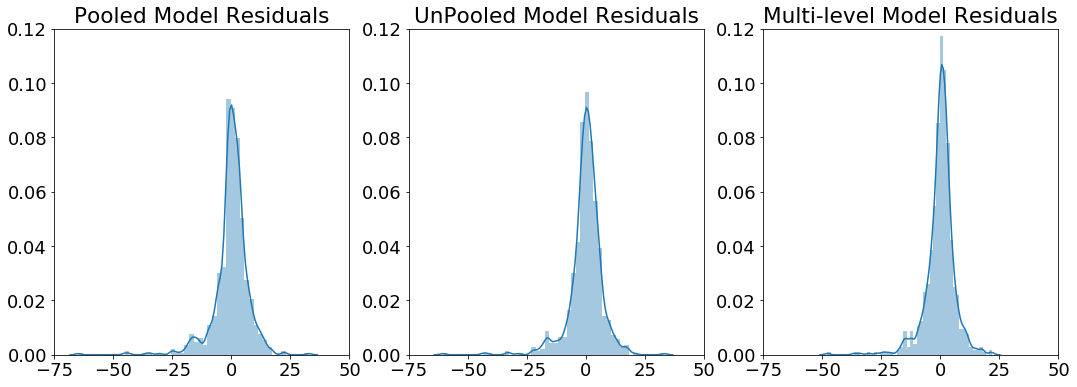

In [587]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
sns.distplot(pooled_resid, ax=ax1)
sns.distplot(unpooled_resid, ax=ax2)
sns.distplot(multi_resid, ax=ax3)
ax1.set_title('Pooled Model Residuals')
ax1.set_ylim(0, 0.12)
ax1.set_xlim(-75, 50)
ax2.set_title('UnPooled Model Residuals')
ax2.set_ylim(0, 0.12)
ax2.set_xlim(-75, 50)
ax3.set_title('Multi-level Model Residuals')
ax3.set_ylim(0, 0.12)
ax3.set_xlim(-75, 50);

In [404]:
summary(multi_trace_4f)


mu_intercep:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  14.965           0.432            0.025            [14.180, 15.849]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  14.105         14.691         14.974         15.255         15.779


mu_beta1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  8.300            0.718            0.041            [6.886, 9.652]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  6.889          7.792          8.290          8.800          9.694


mu_beta2:

  Mean             SD               MC Error         95% HPD interval
  ----------

In [512]:
lst = []
for name in multi_trace_4f.varnames:
    avg = multi_trace_4f[name].mean(axis=0)
    lower = np.percentile(multi_trace_4f[name], 2.5, axis=0)
    upper = np.percentile(multi_trace_4f[name], 97.5, axis=0)
    if type(avg) == np.ndarray:
        lst.append(avg)
        lst.append(lower)
        lst.append(upper)

In [649]:
coeff_df = pd.DataFrame(lst)
coeff_df = coeff_df.T
coeff_df.columns = ['intercept_mean', 'intercept_lower', 'intercept_upper',
                    'HIVprevalence_beta_mean', 'HIVprevalence_beta_lower', 'HIVprevalence_beta_upper',
                    'perc_black_beta_mean', 'perc_black_beta_lower', 'perc_black_beta_upper',
                    'pctunins_beta_mean', 'pctunins_beta_lower', 'pctunins_beta_upper',
                    'log_household_income_beta_mean', 'log_household_income_beta_lower', 'log_household_income_beta_upper']
coeff_df['state'] =  us_states
coeff_df.to_csv('output_tables/multimodel_coeff.csv')
coeff_df

,intercept_mean,intercept_lower,intercept_upper,HIVprevalence_beta_mean,HIVprevalence_beta_lower,HIVprevalence_beta_upper,perc_black_beta_mean,perc_black_beta_lower,perc_black_beta_upper,pctunins_beta_mean,pctunins_beta_lower,pctunins_beta_upper,log_household_income_beta_mean,log_household_income_beta_lower,log_household_income_beta_upper,state
0,15.243598,13.278229,17.149901,12.522004,8.479018,16.838716,3.423800,1.540646,5.350440,1.277781,-1.441351,4.440980,-6.246479,-9.023618,-3.489946,AL
1,14.844114,11.774707,17.518713,8.705774,3.693847,14.321209,3.053605,-0.237697,5.570791,0.096790,-3.369449,3.501091,-0.229228,-6.271355,5.542370,AK
2,14.917707,12.479285,17.477278,8.860826,4.007232,13.740775,3.210959,0.921785,5.742254,0.646669,-2.113808,3.232875,-0.183218,-3.351970,3.226363,AZ
3,15.427357,13.534590,17.899139,7.255058,2.395174,11.595148,2.389867,-0.348197,4.402989,0.611201,-2.973713,3.737398,-2.194164,-6.492711,1.853884,AR
4,14.517229,12.117849,16.425295,6.062520,3.761273,8.252910,3.532659,1.492332,5.990555,1.062759,-1.332079,3.600899,0.667984,-1.335508,2.743707,CA
5,14.993346,12.728520,17.248261,6.768000,3.368690,10.400758,2.982564,0.316173,5.287929,0.742506,-1.892944,3.123477,-2.505922,-6.366076,1.168546,CO
6,14.672580,11.984857,17.029709,8.268012,2.887051,13.719539,3.305353,0.550547,6.093720,0.708595,-2.245524,3.407344,-2.010511,-6.210517,2.107729,CT
7,14.702249,11.886006,17.137901,7.839958,1.774780,13.092166,3.008749,0.094333,5.670353,0.781929,-2.330950,4.382022,-1.245551,-7.679321,5.052852,DE
8,14.859295,12.190091,17.424333,5.698533,3.850079,7.696939,2.928313,-0.418762,5.892401,0.381480,-3.513985,3.726207,-0.685113,-6.758602,6.113374,DC
9,14.717417,13.010684,16.420733,5.596854,4.211609,6.900296,4.149888,2.268464,6.591607,1.901850,0.209059,3.736918,2.211679,0.484026,3.890336,FL


In [713]:
df_new = pd.DataFrame(X)
df_new.columns = ['HIVprevalence', 'perc_black', 'pctunins', 'log_household_income']
df_new['state'] = df_no_zero_outlier.STATEABBREVIATION.values
df_new.head()

,HIVprevalence,perc_black,pctunins,log_household_income,state
0,-0.284378,0.077720,-0.639098,-0.977629,AL
1,-0.500774,-0.492544,-0.039521,0.140330,AL
2,-0.741409,-0.987609,-0.328972,-0.950949,AL
3,1.352293,3.392771,1.014907,-2.453293,AL
4,-0.334612,0.234386,-0.266947,-0.276045,AL


In [714]:
merge_df = pd.merge(df_new, coeff_df, how='left', on='state')
merge_df.head()

,HIVprevalence,perc_black,pctunins,log_household_income,state,intercept_mean,intercept_lower,intercept_upper,HIVprevalence_beta_mean,HIVprevalence_beta_lower,HIVprevalence_beta_upper,perc_black_beta_mean,perc_black_beta_lower,perc_black_beta_upper,pctunins_beta_mean,pctunins_beta_lower,pctunins_beta_upper,log_household_income_beta_mean,log_household_income_beta_lower,log_household_income_beta_upper
0,-0.284378,0.077720,-0.639098,-0.977629,AL,15.243598,13.278229,17.149901,12.522004,8.479018,16.838716,3.4238,1.540646,5.35044,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946
1,-0.500774,-0.492544,-0.039521,0.140330,AL,15.243598,13.278229,17.149901,12.522004,8.479018,16.838716,3.4238,1.540646,5.35044,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946
2,-0.741409,-0.987609,-0.328972,-0.950949,AL,15.243598,13.278229,17.149901,12.522004,8.479018,16.838716,3.4238,1.540646,5.35044,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946
3,1.352293,3.392771,1.014907,-2.453293,AL,15.243598,13.278229,17.149901,12.522004,8.479018,16.838716,3.4238,1.540646,5.35044,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946
4,-0.334612,0.234386,-0.266947,-0.276045,AL,15.243598,13.278229,17.149901,12.522004,8.479018,16.838716,3.4238,1.540646,5.35044,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946


In [715]:
merge_df['pred'] = merge_df.intercept_mean + merge_df.HIVprevalence * merge_df.HIVprevalence_beta_mean + merge_df.perc_black * merge_df.perc_black_beta_mean + merge_df.pctunins * merge_df.pctunins_beta_mean + merge_df.log_household_income * merge_df.log_household_income_beta_mean
merge_df['actual'] = df_no_zero_outlier.HIVincidence.values
merge_df['county_code'] = df_no_zero_outlier.county_code.values
merge_df.head()

,HIVprevalence,perc_black,pctunins,log_household_income,state,intercept_mean,intercept_lower,intercept_upper,HIVprevalence_beta_mean,HIVprevalence_beta_lower,...,perc_black_beta_upper,pctunins_beta_mean,pctunins_beta_lower,pctunins_beta_upper,log_household_income_beta_mean,log_household_income_beta_lower,log_household_income_beta_upper,pred,actual,county_code
0,-0.284378,0.077720,-0.639098,-0.977629,AL,15.243598,13.278229,17.149901,12.522004,8.479018,...,5.35044,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946,17.238827,10.9,1001
1,-0.500774,-0.492544,-0.039521,0.140330,AL,15.243598,13.278229,17.149901,12.522004,8.479018,...,5.35044,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946,6.359471,8.7,1003
2,-0.741409,-0.987609,-0.328972,-0.950949,AL,15.243598,13.278229,17.149901,12.522004,8.479018,...,5.35044,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946,8.098032,10.4,1009
3,1.352293,3.392771,1.014907,-2.453293,AL,15.243598,13.278229,17.149901,12.522004,8.479018,...,5.35044,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946,60.414453,90.7,1011
4,-0.334612,0.234386,-0.266947,-0.276045,AL,15.243598,13.278229,17.149901,12.522004,8.479018,...,5.35044,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946,13.239277,10.3,1015


In [716]:
merge_df['county_code'] = merge_df.county_code.astype(str)
merge_df['county_code'] = ['0' + x if len(x) < 5 else x for x in merge_df.county_code.values]
merge_df['residual'] = merge_df.actual - merge_df.pred
merge_df.to_csv('output_tables/multimodel_table.txt')
merge_df.head()

,HIVprevalence,perc_black,pctunins,log_household_income,state,intercept_mean,intercept_lower,intercept_upper,HIVprevalence_beta_mean,HIVprevalence_beta_lower,...,pctunins_beta_mean,pctunins_beta_lower,pctunins_beta_upper,log_household_income_beta_mean,log_household_income_beta_lower,log_household_income_beta_upper,pred,actual,county_code,residual
0,-0.284378,0.077720,-0.639098,-0.977629,AL,15.243598,13.278229,17.149901,12.522004,8.479018,...,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946,17.238827,10.9,01001,-6.338827
1,-0.500774,-0.492544,-0.039521,0.140330,AL,15.243598,13.278229,17.149901,12.522004,8.479018,...,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946,6.359471,8.7,01003,2.340529
2,-0.741409,-0.987609,-0.328972,-0.950949,AL,15.243598,13.278229,17.149901,12.522004,8.479018,...,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946,8.098032,10.4,01009,2.301968
3,1.352293,3.392771,1.014907,-2.453293,AL,15.243598,13.278229,17.149901,12.522004,8.479018,...,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946,60.414453,90.7,01011,30.285547
4,-0.334612,0.234386,-0.266947,-0.276045,AL,15.243598,13.278229,17.149901,12.522004,8.479018,...,1.277781,-1.441351,4.44098,-6.246479,-9.023618,-3.489946,13.239277,10.3,01015,-2.939277


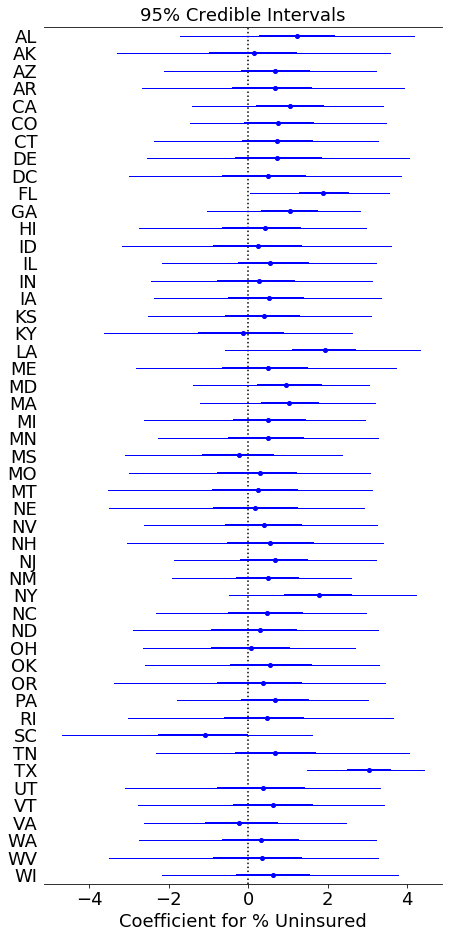

In [745]:
plt.figure(figsize=(6,14))
forestplot(multi_trace_4f, varnames=['beta3'], ylabels=us_states, xtitle='Coefficient for % Uninsured')
plt.rcParams.update({'font.size': 18})
plt.savefig('images/perc_unins_forestplot.png', bbox_inches='tight');

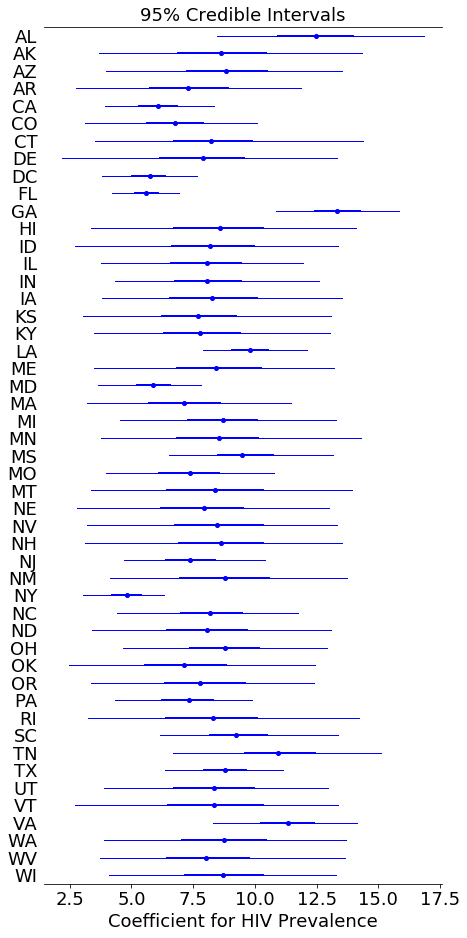

In [757]:
plt.figure(figsize=(6,14))
forestplot(multi_trace_4f, varnames=['beta1'], ylabels=us_states, xtitle='Coefficient for HIV Prevalence')
plt.rcParams.update({'font.size': 18})
plt.savefig('images/hiv_prev_forestplot_hi_res.png', dpi=600, bbox_inches='tight');

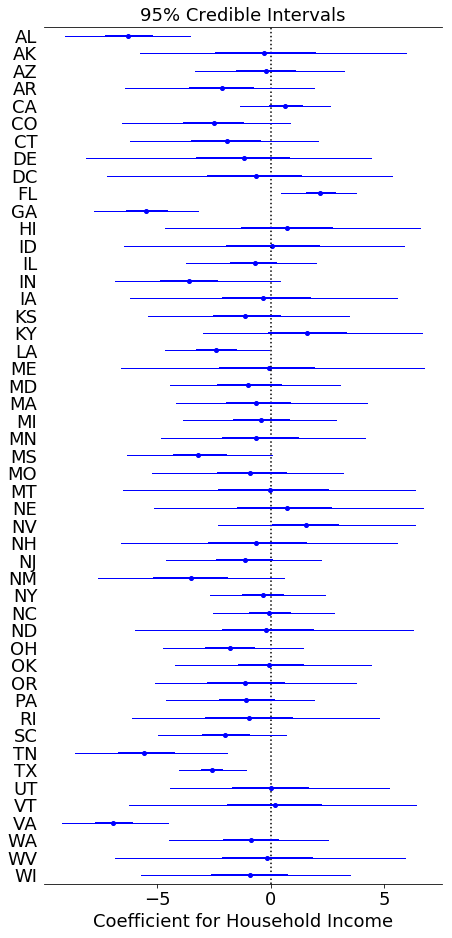

In [756]:
plt.figure(figsize=(6,14))
forestplot(multi_trace_4f, varnames=['beta4'], ylabels=us_states, xtitle='Coefficient for Household Income')
plt.rcParams.update({'font.size': 18})
plt.savefig('images/log_house_income_forestplot.png', bbox_inches='tight');

In [741]:
def index_sig_traces(df, lower_col_name, upper_col_name):
    sig_list_pos = df.state[(df[lower_col_name] > 0) & (df[upper_col_name] > 0)]
    sig_list_neg = df.state[(df[lower_col_name] < 0) & (df[upper_col_name] < 0)]
    if len(sig_list_pos) > 0 and len(sig_list_pos) > 0:
        return np.concatenate((sig_list_pos.values, sig_list_neg.values))
    elif len(sig_list_pos) > 0:
        return sig_list_pos
    elif len(sig_list_neg) > 0:
        return sig_list_neg
    else:
        return None


In [752]:
def plot_trace(trace, beta_name, iter_list, color_list):
    plt.figure(figsize=(10,8))
    for i, label in enumerate(iter_list):
        if label in color_list:
            sns.distplot(trace[beta_name][:,i], hist=False, kde_kws={"lw": 5}, label=label)
        else:
            sns.distplot(trace[beta_name][:,i], hist=False, color='k', kde_kws={"alpha": 0.1})
            
# def plot_trace(trace, beta_name, iter_list, color_list):
#     plt.figure(figsize=(10,8))
#     for i, label in enumerate(iter_list):
#         if label not in color_list:
#             sns.distplot(trace[beta_name][:,i], hist=False, color='k', kde_kws={"alpha": 0.3})
#     for i, label in enumerate(color_list):
#         sns.distplot(trace[beta_name][:,i], hist=False, kde_kws={"lw": 7}, label=label)

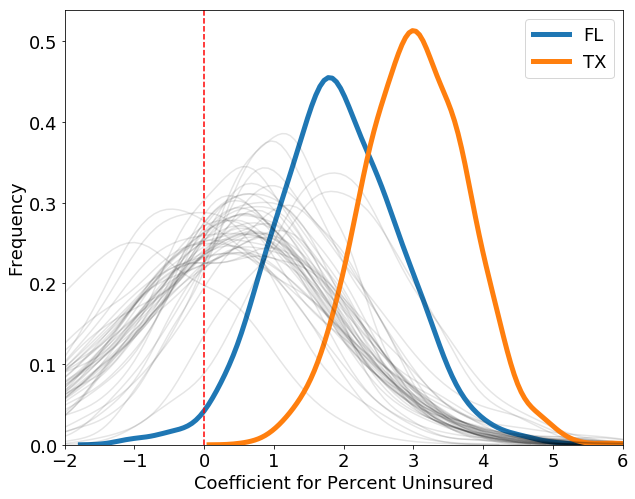

In [758]:
beta3_sig =  index_sig_traces(coeff_df, 'pctunins_beta_lower', 'pctunins_beta_upper')
plot_trace(multi_trace_4f, 'beta3', us_states, beta3_sig)
plt.axvline(0, color='r', linestyle='dashed')
plt.xlim(-2, 6)
plt.xlabel('Coefficient for Percent Uninsured')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('images/perc_unins_coeff_trace_hi_res.png', dpi=600, bbox_inches='tight');

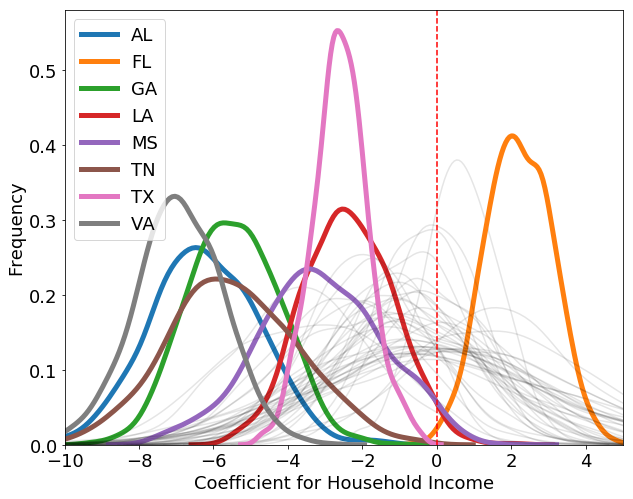

In [759]:
beta4_sig =  index_sig_traces(coeff_df, 'log_household_income_beta_lower', 'log_household_income_beta_upper')
plot_trace(multi_trace_4f, 'beta4', us_states, beta4_sig)
plt.axvline(0, color='r', linestyle='dashed')
plt.xlim(-10, 5)
plt.xlabel('Coefficient for Household Income')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('images/house_income_coeff_trace_hi_res.png', dpi=600, bbox_inches='tight');